# Comparing with `matlab` Baselines

This code is ported from `matlab` scripts.
Before adding features, we tested a variety of simulations to ensure answers are close (typically within round-off) of the `matlab` solutions.

First we ran a test case with 9 columns and analytic forcing fields, that can be run with `matlab_script = 'test_case'`.
Next we read in forcing for three locations from netCDF files; that test can be run with `matlab_script = 'test_locs3'`.
Finally, we read in forcing from the CESM FOSI run.
For exact reproduction, that test can be run with `matlab_script = 'FOSI_cesm_daily'`.

## Additional Improvements

After verifying we could reproduce the `matlab` solutions with daily forcing, we then added the ability to interpolate from monthly forcing.
We also modified how the interpolation is done:

1. We kept the dates from the CESM FOSI simulation, rather than assuming the output was evenly spaced 30 days apart each year
1. We apply a floor of 0 for the zooplankton mortality, rather than using the minimum value over the calendar year
1. We do not extrapolate prior to the first level or after the last time level; instead, we use the first or last level, respectively.

Due to these changes, running `matlab_script = 'FOSI_cesm'` will not be within round-off of the `matlab` runs.
Similarly, `matlab_script = 'FOSI_cesm_spinup'` uses cyclic forcing from the first year but with the above changes to interpolation so the resulting initial conditions will not match the `matlab` output.

## Running the model

Setup a `feisty` integration.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml
from utils import compare_nc, default_config, old_settings

import feisty

## Configure run

There are a few options on how to run:

1. `test_case` uses an idealized testcase where forcing and depth are computed analytically
1. `test_locs3` is a simple model where three columns were pulled from a larger run for quick testing
1. `FOSI_spinup` cycles through the first year of 68 years of forcing generated from a CESM; its purpose is to provide equilibriated initial conditions
1. `FOSI_cesm` uses initial conditions from `FOSI_spinup` but the full 68 years of forcing from CESM to allow biomass to evolve

Note that both of the `FOSI` options run on the 85813 active ocean cells from the POP `gx1v7` grid.

In [3]:
# matlab_script = 'test_case'
# matlab_script = 'test_locs3'
# matlab_script = 'FOSI_spinup'
matlab_script = 'FOSI_cesm'

In [4]:
# Configuration settings for the offline driver as well as output generated in this notebook
driver_config = default_config()

# configurations that differ from default
driver_config['test_case']['ignore_year_in_forcing'] = True
driver_config['test_case']['make_err_plots'] = True
driver_config['test_case']['plot_settings']['ylim'] = [1e-6, 1]

driver_config['test_locs3']['ignore_year_in_forcing'] = True
driver_config['test_locs3']['nyears'] = 2
driver_config['test_locs3']['max_output_time_dim'] = 730
driver_config['test_locs3']['make_err_plots'] = True
driver_config['test_locs3']['plot_settings']['ylim'] = [1e-6, 100]

driver_config['FOSI_spinup']['ignore_year_in_forcing'] = True
driver_config['FOSI_cesm']['nyears'] = 2
driver_config['FOSI_spinup']['nyears'] = 100
for matlab_script_loc in ['FOSI_cesm', 'FOSI_cesm_daily', 'FOSI_spinup']:
    driver_config[matlab_script_loc]['baseline'] = 'FOSI_cesm.nc'
    driver_config[matlab_script_loc]['baseline_compare'] = False
    if matlab_script_loc != 'FOSI_spinup':
        driver_config[matlab_script_loc]['start_date'] = '0249-01-01'
        driver_config[matlab_script_loc]['make_err_plots'] = True
    driver_config[matlab_script_loc]['compare_forcing'] = False
    # diagnostic_names=driver_config[matlab_script_loc]['diagnostic_names'] = ['growth_rate']
    driver_config[matlab_script_loc]['plot_settings']['X'] = 55000  # looks good
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 15633  # large error in small classes
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 11677  # large error in medium classes
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 76989  # large error in benthic

for matlab_script_loc in ['test_case', 'test_locs3']:
    driver_config[matlab_script_loc]['settings_in'] = old_settings()

In [5]:
baselines_from_nc = xr.open_dataset(
    f'../matlab_baselines/{driver_config[matlab_script]["baseline"]}'
)

if matlab_script not in driver_config:
    raise ValueError(f"unknown matlab_script '{matlab_script}'")

if matlab_script == 'test_case':
    feisty_driver = feisty.config_testcase(
        'tanh_shelf',
        'cyclic',
        settings_in=driver_config[matlab_script]['settings_in'],
        max_output_time_dim=driver_config[matlab_script]['max_output_time_dim'],
    )
else:
    feisty_driver = feisty.config_from_netcdf(
        './forcing.yaml',
        matlab_script,
        start_date=driver_config[matlab_script]['start_date'],
        ignore_year_in_forcing=driver_config[matlab_script]['ignore_year_in_forcing'],  # True,
        settings_in=driver_config[matlab_script]['settings_in'],
        diagnostic_names=driver_config[matlab_script]['diagnostic_names'],
        max_output_time_dim=driver_config[matlab_script]['max_output_time_dim'],
    )

# Set negative forcing values to zero
if driver_config[matlab_script]['force_nonnegative']:
    for var in ['poc_flux_bottom', 'zooC', 'zoo_mort']:
        baselines_from_nc[var].data = np.where(
            baselines_from_nc[var].data > 0, baselines_from_nc[var].data, 0
        )

In [6]:
if driver_config[matlab_script]['compare_forcing']:
    if feisty_driver.ignore_year:
        new_forcing = feisty_driver.forcing.isel(forcing_time=slice(1, -1)).transpose(
            'zooplankton', 'forcing_time', 'X'
        )
    else:
        new_forcing = feisty_driver.forcing.transpose('zooplankton', 'forcing_time', 'X')
    compare_nc(
        baselines_from_nc,
        new_forcing,
        time_name="forcing_time",
    )

    print(
        f"\nMax diff in depth: {np.max(np.abs(baselines_from_nc['dep'].data - feisty_driver.obj.domain_dict['bathymetry'].data))}"
    )

## Run the model

In [7]:
print(f'Running {matlab_script}...')
nsteps = driver_config[matlab_script]['nyears'] * 365
%time feisty_driver.run(nsteps)

Running FOSI_cesm...
Starting run() at 14:32:38
Integrating 730 steps (starting at 14:32:39)
Starting a new output dataset for timestep 365 (14:33:37)
Finished _solve at 14:34:36
CPU times: user 1min 56s, sys: 1.74 s, total: 1min 58s
Wall time: 1min 58s


In [8]:
if 'new_restart_file' in driver_config[matlab_script]:
    feisty_driver.create_restart_file(driver_config[matlab_script]['new_restart_file'])

In [9]:
%time feisty_driver.gen_ds()

CPU times: user 822 ms, sys: 846 ms, total: 1.67 s
Wall time: 1.67 s


In [10]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(baselines_from_nc, feisty_driver.ds["biomass"], nsteps, thres=1e-15)

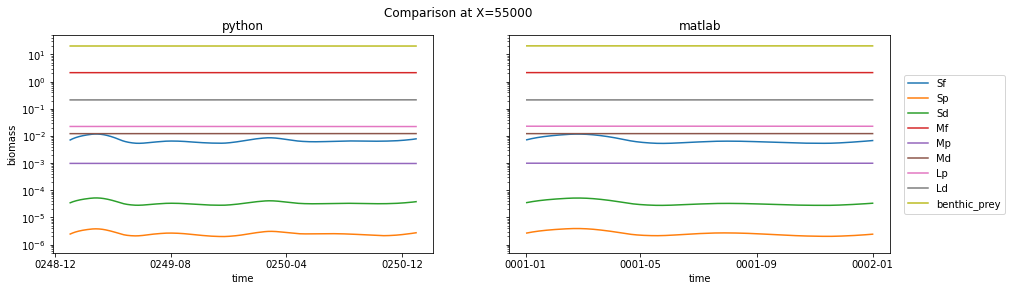

In [11]:
if driver_config[matlab_script]['make_plots']:
    if len(baselines_from_nc.time) > len(feisty_driver.ds.time):
        isel_dict = {"time": range(len(feisty_driver.ds.time))}
        baselines_tmp = baselines_from_nc.isel(isel_dict).assign_coords(
            {'group': feisty_driver.ds.group.data, 'time': feisty_driver.ds.time.data}
        )
    else:
        baselines_tmp = baselines_from_nc.assign_coords({'group': feisty_driver.ds.group.data})
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in feisty_driver.ds.group.data:
        feisty_driver.ds.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[0])
        baselines_tmp.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[1])
    for ax in axs:
        ax.set_ylim(driver_config[matlab_script]['plot_settings']['ylim'])
        ax.set_yscale("log")
    axs[0].set_title("python")
    axs[1].set_title("matlab")
    axs[1].set_ylabel("")
    axs[1].set_yticklabels("")
    plt.legend(feisty_driver.ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    fig.suptitle(f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}")

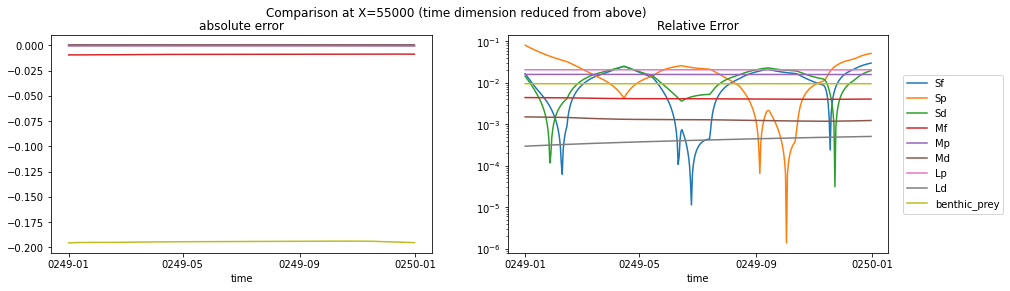

In [12]:
if driver_config[matlab_script]['make_err_plots']:
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in feisty_driver.ds.group.data:
        da1 = feisty_driver.ds.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        )
        if len(baselines_from_nc.time) < len(feisty_driver.ds.time):
            da1 = da1.isel({"time": range(len(baselines_from_nc.time))})
        da2 = (
            baselines_tmp.biomass.sel(group=group)
            .isel(X=driver_config[matlab_script]['plot_settings']['X'])
            .assign_coords({'time': da1.time.data})
        )
        (da1 - da2).plot(ax=axs[0])
        (np.abs(da1 - da2) / da2).plot(ax=axs[1])
    axs[0].set_title("absolute error")
    axs[0].set_ylabel("")
    axs[1].set_title("relative error")
    axs[1].set_ylabel("")
    axs[1].set_yscale("log")
    plt.legend(feisty_driver.ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    plt.title("Relative Error")
    fig_suptitle = f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}"
    if len(baselines_from_nc.time) < len(feisty_driver.ds.time):
        fig_suptitle = f"{fig_suptitle} (time dimension reduced from above)"
    fig.suptitle(fig_suptitle)

In [13]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(
        baselines_from_nc.isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        feisty_driver.ds["biomass"].isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        nsteps,
        thres=1e-15,
    )